# Logistic Regression Experiments

Imports and Helper Functions
---

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim


## Model Creation

In [ ]:
#Define a basic LR with pyTorch
class LR(nn.Module):
    def __init__(self, D):
        super(LR, self).__init__()
        self.fc1 = nn.Linear(D,1)
        self.fc1.weight.data.zero_()
        self.fc1.bias.data.zero_()

    def predict(self,X):
        z = self.fc1(X)
        return 0.0+(torch.sigmoid(z)>=0.5)
    
    def forward(self, X):
        z = self.fc1(X)
        return torch.sigmoid(z)
    
    def logits(self, X):
        """Return raw logits (before sigmoid)"""
        return self.fc1(X)

    def fit(self, X, y, lr=1, maxiter=100):
        optimizer = optim.SGD(self.parameters(), lr=lr)
        loss_values=[]

        for epoch in range(maxiter):
            optimizer.zero_grad()
            p = self.forward(X)
            loss = -1*torch.mean(y*torch.log(p) + (1-y)*torch.log(1-p))        

            if(torch.isnan(loss)):
                print("Warning: loss is nan. Aborting learning. Try decreasing the step size.")
                break

            loss.backward()
            optimizer.step()
            
            loss_values.append(loss.detach().item())

        return(loss_values)

# Improved LR class with logits method
class LRImproved(nn.Module):
    def __init__(self, D):
        super(LRImproved, self).__init__()
        self.fc1 = nn.Linear(D,1)
        self.fc1.weight.data.zero_()
        self.fc1.bias.data.zero_()

    def predict(self,X):
        z = self.fc1(X)
        return 0.0+(torch.sigmoid(z)>=0.5)
    
    def forward(self, X):
        z = self.fc1(X)
        return torch.sigmoid(z)
    
    def logits(self, X):
        """Return raw logits (before sigmoid)"""
        return self.fc1(X)

    def fit(self, X, y, lr=1, maxiter=100):
        optimizer = optim.SGD(self.parameters(), lr=lr)
        loss_values=[]

        for epoch in range(maxiter):
            optimizer.zero_grad()
            p = self.forward(X)
            loss = -1*torch.mean(y*torch.log(p) + (1-y)*torch.log(1-p))        

            if(torch.isnan(loss)):
                print("Warning: loss is nan. Aborting learning. Try decreasing the step size.")
                break

            loss.backward()
            optimizer.step()
            
            loss_values.append(loss.detach().item())

        return(loss_values) 


## Load data

In [3]:
data = torch.load("data.pt",weights_only=False)
X = data["X"]
y = data["y"]

## Question 3a

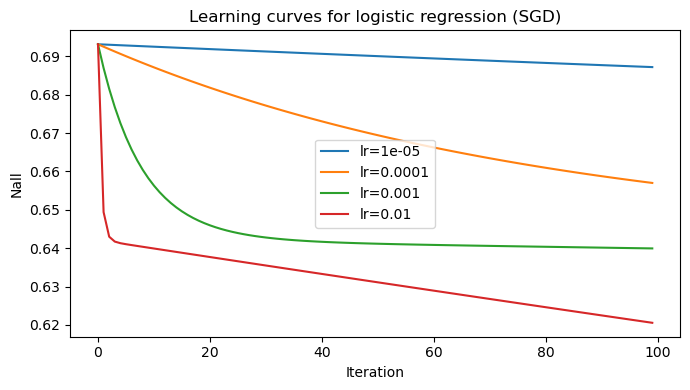

Training error rates:
lr=1e-05  : 0.5000
lr=0.0001 : 0.5000
lr=0.001  : 0.5000
lr=0.01   : 0.5000


In [34]:
lrs = [1e-5, 1e-4, 1e-3, 1e-2]
graph = {}
errors = {}

D = X.shape[1]
for lr in lrs:
    model_lr = LR(D)
    nalls = model_lr.fit(X, y, lr=lr, maxiter=100)
    graph[lr] = nalls
    with torch.no_grad():
        y_hat = model_lr.predict(X)
        err = (y_hat != y).float().mean().item()
    errors[lr] = err

plt.figure(figsize=(7, 4))
for lr, nalls in graph.items():
    plt.plot(nalls, label=f"lr={lr}")
plt.xlabel("Iteration")
plt.ylabel("Nall")
plt.title("Learning curves for logistic regression (SGD)")
plt.legend()
plt.tight_layout()
plt.show()

print("Training error rates:")
for lr in lrs:
    print(f"lr={lr:<7}: {errors[lr]:.4f}")

## Question 3b

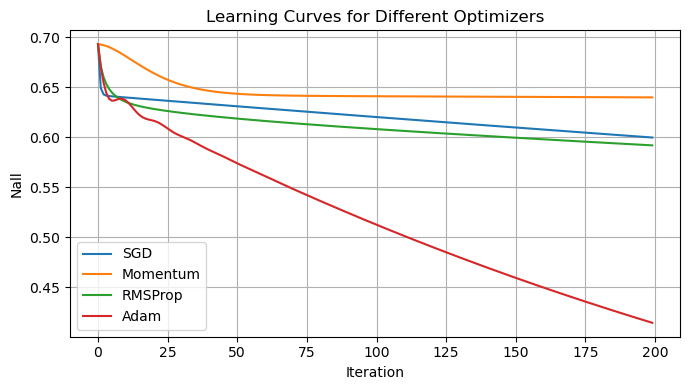

Training error rates:
SGD       : 0.4970
Momentum  : 0.5000
RMSProp   : 0.4890
Adam      : 0.0810

 Best optimizer: Adam


In [9]:
def train_with_optimizer(model_class, X, y, optimizer_name="SGD", lr=1e-3, maxiter=200):
    model = model_class(X.shape[1])
    criterion = nn.BCELoss()

    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name == "Momentum":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer_name == "RMSProp":
        optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError("Unknown optimizer")

    nalls = []
    for _ in range(maxiter):
        optimizer.zero_grad()
        preds = model.forward(X)         
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        nalls.append(loss.item())

    with torch.no_grad():
        y_hat = model.predict(X)
        err = (y_hat != y).float().mean().item()

    return nalls, err


optimizers = ["SGD", "Momentum", "RMSProp", "Adam"]
lrs = {"SGD": 1e-2, "Momentum": 5e-5, "RMSProp": 1e-3, "Adam": 1e-2}
weight_decay = 1e-4

graph_opt = {}
errors_opt = {}

for opt in optimizers:
    nalls, err = train_with_optimizer(LR, X, y, optimizer_name=opt, lr=lrs[opt], maxiter=200)
    graph_opt[opt] = nalls
    errors_opt[opt] = err


plt.figure(figsize=(7,4))
for opt, nalls in graph_opt.items():
    plt.plot(nalls, label=opt)
plt.xlabel("Iteration")
plt.ylabel("Nall")
plt.title("Learning Curves for Different Optimizers")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


print("Training error rates:")
for opt in optimizers:
    print(f"{opt:<10}: {errors_opt[opt]:.4f}")


best_opt = min(errors_opt, key=errors_opt.get)
print(f"\n Best optimizer: {best_opt}")

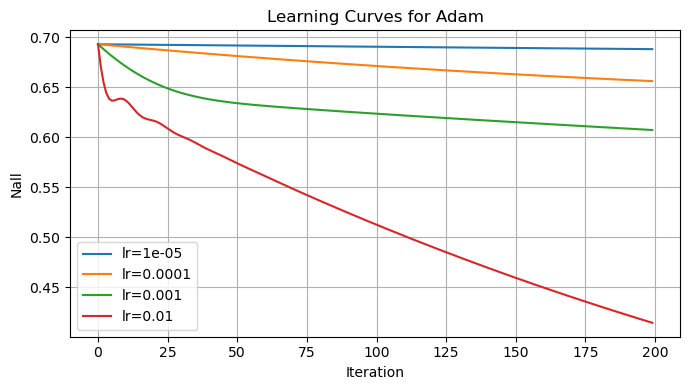

Training error rates for Adam:
lr=1e-05  : 0.5000
lr=0.0001 : 0.5000
lr=0.001  : 0.4990
lr=0.01   : 0.0810


In [10]:
def train_with_best_optimizer(model_class, X, y, optimizer_name, lr=1e-3, maxiter=200):
    model = model_class(X.shape[1])
    criterion = nn.BCELoss()

    if optimizer_name == "Momentum":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer_name == "RMSProp":
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)

    nalls = []
    for _ in range(maxiter):
        optimizer.zero_grad()
        preds = model.forward(X)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        nalls.append(loss.item())

    with torch.no_grad():
        y_hat = model.predict(X)
        err = (y_hat != y).float().mean().item()

    return nalls, err

lrs_test = [1e-5, 1e-4, 1e-3, 1e-2]
graph_lr = {}
errors_lr = {}

for lr in lrs_test:
    nalls, err = train_with_best_optimizer(LR, X, y, optimizer_name=best_opt, lr=lr, maxiter=200)
    graph_lr[lr] = nalls
    errors_lr[lr] = err

plt.figure(figsize=(7, 4))
for lr, nalls in graph_lr.items():
    plt.plot(nalls, label=f"lr={lr}")
plt.xlabel("Iteration")
plt.ylabel("Nall")
plt.title(f"Learning Curves for {best_opt}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Training error rates for {best_opt}:")
for lr in lrs_test:
    print(f"lr={lr:<7}: {errors_lr[lr]:.4f}")

## Question 3c

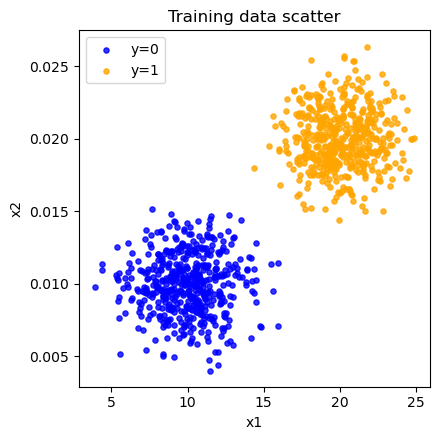

Short-run comparison -> base err: 0.5000, 
standardized+stable-loss err: 0.0000


In [24]:
#Add yuor code below
def logits(self, X):
    return self.fc1(X)
LR.logits = logits

if X.shape[1] == 2:
    plt.figure(figsize=(4.5, 4.5))
    pos = (y.view(-1) == 1)
    neg = ~pos
    plt.scatter(X[neg, 0], X[neg, 1], c="blue", s=14, label="y=0", alpha=0.8)
    plt.scatter(X[pos, 0], X[pos, 1], c="orange", s=14, label="y=1", alpha=0.8)
    plt.legend()
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("Training data scatter")
    plt.tight_layout()
    plt.show()

X_mean = X.mean(dim=0, keepdim=True)
X_std = X.std(dim=0, keepdim=True)
X_std = torch.where(X_std == 0, torch.ones_like(X_std), X_std)
Xn = (X - X_mean) / (X_std + 1e-8)

base = LR(X.shape[1])
w = base.fit(X, y, lr=1e-3, maxiter=10)
imp = LR(X.shape[1])
criterion = nn.BCEWithLogitsLoss()
opt = optim.SGD(imp.parameters(), lr=1e-1)
for _ in range(10):
    opt.zero_grad()
    loss = criterion(imp.logits(Xn), y)
    loss.backward()
    opt.step()

with torch.no_grad():
    err_base = (base.predict(X) != y).float().mean().item()
    err_imp = (imp.predict(Xn) != y).float().mean().item()
print(f"Short-run comparison -> base err: {err_base:.4f}, \nstandardized+stable-loss err: {err_imp:.4f}")